# Relatório Técnico – Cotações do Dólar (Banco Central)

Este relatório apresenta o processo de ETL e a análise exploratória das cotações do dólar americano (USD) frente ao real (BRL), com dados extraídos da API oficial do Banco Central do Brasil.

## Dicionário de Dados

| Coluna   | Tipo       | Descrição |
|----------|------------|-----------|
| `data`  | datetime64 | Data e hora da cotação |
| `compra` | float64    | Valor de compra (R$/USD) |
| `venda`  | float64    | Valor de venda (R$/USD) |
| `media`  | float64    | Média entre compra e venda |
| `media_movel_7d` | float64 | Média móvel de 7 dias da média |
| `variacao_pct` | float64 | Variação percentual diária da média |

## 1. Extração dos Dados

In [2]:

import requests
import pandas as pd

def extrair_dados_dolar(inicio: str, fim: str) -> pd.DataFrame:
    url = (
        f"https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/"
        f"CotacaoDolarPeriodo(dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)"
        f"?@dataInicial='{inicio}'&@dataFinalCotacao='{fim}'&$top=10000&$format=json"
    )
    response = requests.get(url)
    response.raise_for_status()
    dados = response.json()["value"]
    return pd.DataFrame(dados)

df = extrair_dados_dolar("01-01-2023", "01-06-2023")
df.head()


,cotacaoCompra,cotacaoVenda,dataHoraCotacao
0,5.3430,5.3436,2023-01-02 13:05:57.593
1,5.3753,5.3759,2023-01-03 13:11:19.08
2,5.4453,5.4459,2023-01-04 13:09:19.572
3,5.4020,5.4026,2023-01-05 13:03:32.262
4,5.2849,5.2855,2023-01-06 13:02:28.727


## 2. Transformação dos Dados

In [3]:

df['dataHoraCotacao'] = pd.to_datetime(df['dataHoraCotacao'])
df = df.rename(columns={'cotacaoCompra': 'compra', 'cotacaoVenda': 'venda', 'dataHoraCotacao': 'data'})
df['media'] = df[['compra', 'venda']].mean(axis=1)
df = df[['data', 'compra', 'venda', 'media']].dropna().sort_values('data')


## 3. Estrutura dos Dados

In [4]:

print("Período:", df['data'].min().date(), "a", df['data'].max().date())
print("Total de registros:", len(df))
print("\nTipos de dados:")
print(df.dtypes)
print("\nValores únicos por coluna:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} valores únicos")


Período: 2023-01-02 a 2023-01-06
Total de registros: 5

Tipos de dados:
data      datetime64[ns]
compra           float64
venda            float64
media            float64
dtype: object

Valores únicos por coluna:
data: 5 valores únicos
compra: 5 valores únicos
venda: 5 valores únicos
media: 5 valores únicos


## 4. Análise Exploratória

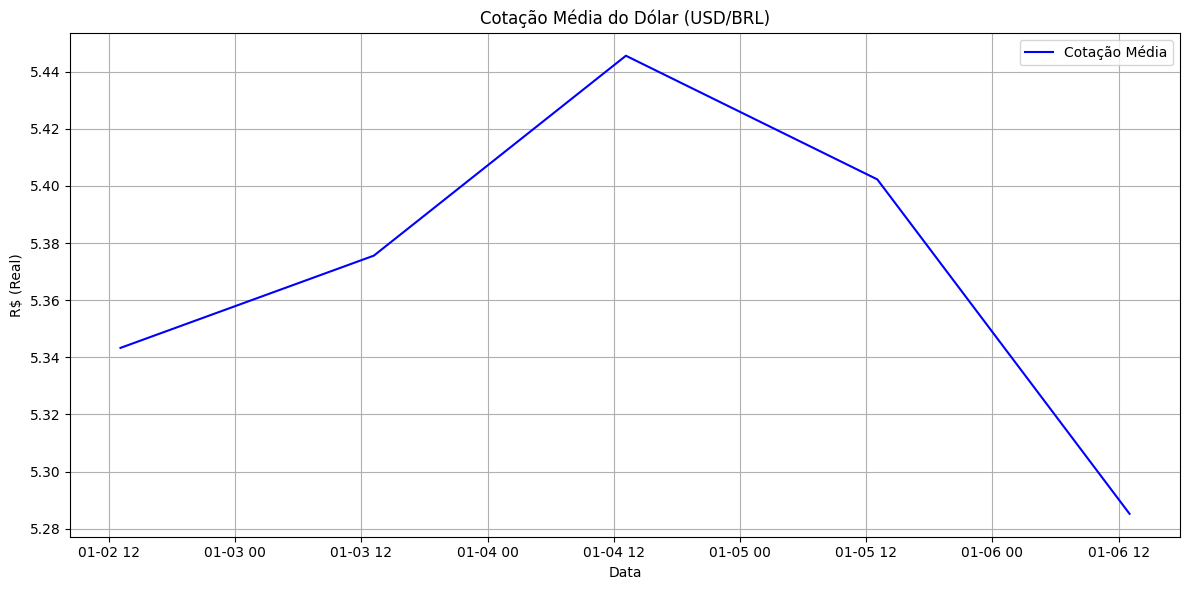

In [5]:

import matplotlib.pyplot as plt
import seaborn as sns

# Cotação média
plt.figure(figsize=(12, 6))
plt.plot(df['data'], df['media'], label='Cotação Média', color='blue')
plt.title("Cotação Média do Dólar (USD/BRL)")
plt.xlabel("Data")
plt.ylabel("R$ (Real)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


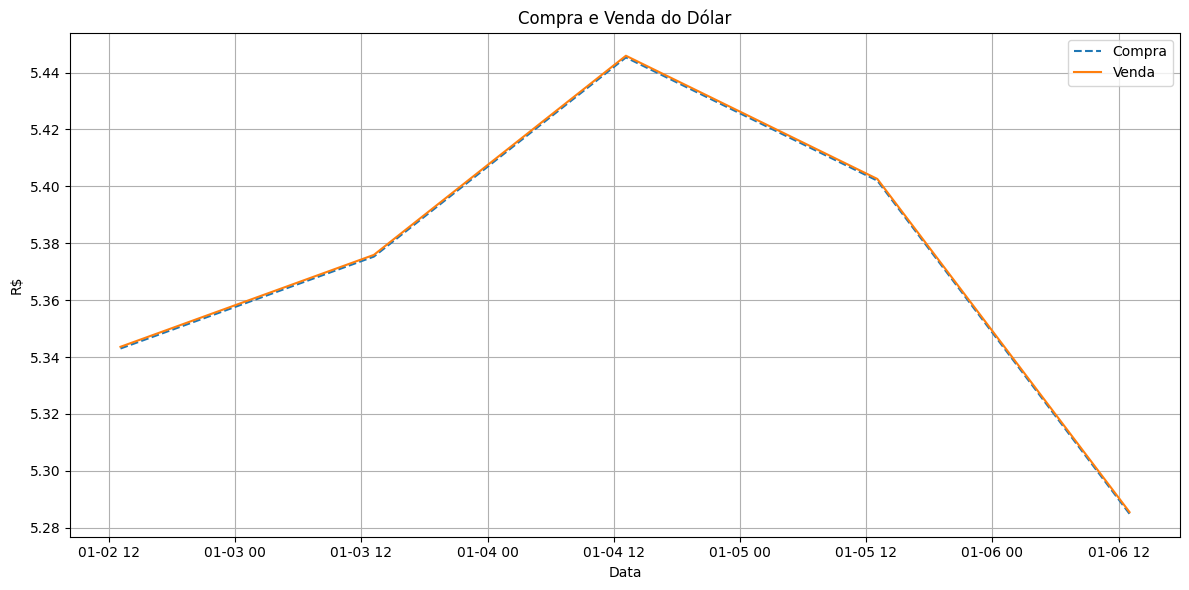

In [6]:

# Compra vs Venda
plt.figure(figsize=(12, 6))
plt.plot(df['data'], df['compra'], label='Compra', linestyle='--')
plt.plot(df['data'], df['venda'], label='Venda')
plt.title("Compra e Venda do Dólar")
plt.xlabel("Data")
plt.ylabel("R$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


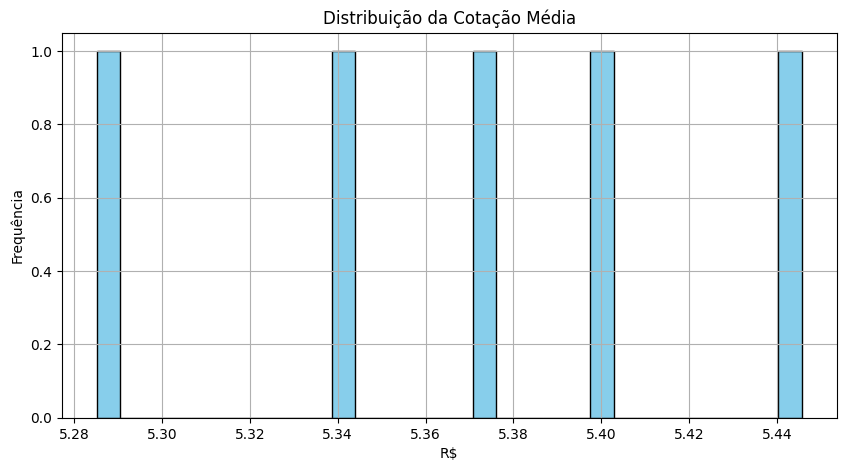

In [7]:

# Histograma
plt.figure(figsize=(10, 5))
plt.hist(df['media'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribuição da Cotação Média")
plt.xlabel("R$")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()


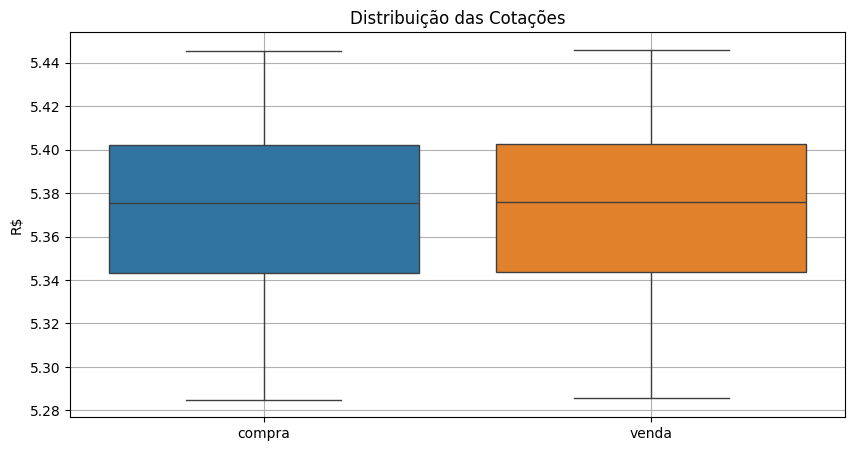

In [8]:

# Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[['compra', 'venda']])
plt.title("Distribuição das Cotações")
plt.ylabel("R$")
plt.grid(True)
plt.show()


## 5. Análises Exploratórias – Textuais

In [9]:

df['media_movel_7d'] = df['media'].rolling(window=7).mean()
df['variacao_pct'] = df['media'].pct_change() * 100

maior = df.loc[df['media'].idxmax()]
menor = df.loc[df['media'].idxmin()]
spread_medio = (df['venda'] - df['compra']).mean()
dias_alta = df[df['variacao_pct'] > 1]
dias_baixa = df[df['variacao_pct'] < -1]

print(f"Maior cotação média: R$ {maior['media']:.2f} em {maior['data'].date()}")
print(f"Menor cotação média: R$ {menor['media']:.2f} em {menor['data'].date()}")
print(f"Spread médio: R$ {spread_medio:.4f}")
print(f"Dias com alta > 1%: {len(dias_alta)}")
print(f"Dias com queda > 1%: {len(dias_baixa)}")


Maior cotação média: R$ 5.45 em 2023-01-04
Menor cotação média: R$ 5.29 em 2023-01-06
Spread médio: R$ 0.0006
Dias com alta > 1%: 1
Dias com queda > 1%: 1


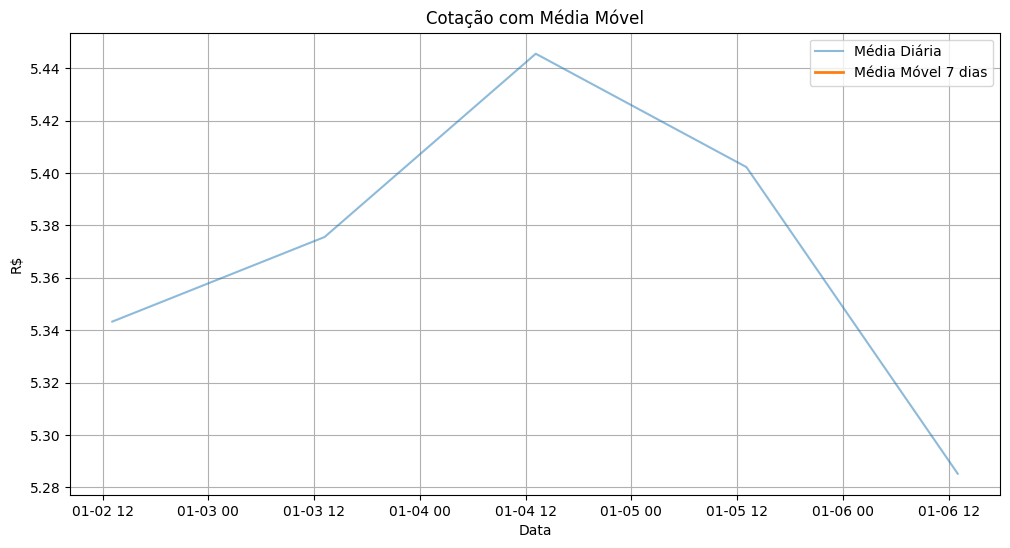

In [10]:

# Gráfico média móvel
plt.figure(figsize=(12, 6))
plt.plot(df['data'], df['media'], alpha=0.5, label='Média Diária')
plt.plot(df['data'], df['media_movel_7d'], label='Média Móvel 7 dias', linewidth=2)
plt.title("Cotação com Média Móvel")
plt.xlabel("Data")
plt.ylabel("R$")
plt.legend()
plt.grid(True)
plt.show()


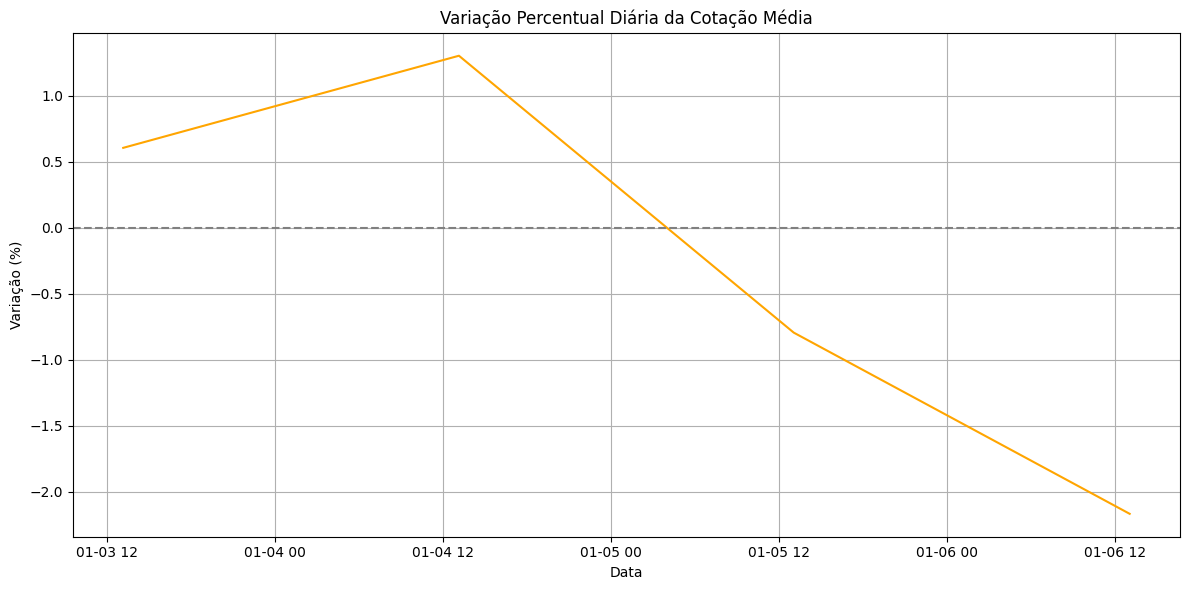

In [11]:

# Gráfico variação percentual
plt.figure(figsize=(12, 6))
plt.plot(df['data'], df['variacao_pct'], color='orange')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Variação Percentual Diária da Cotação Média")
plt.xlabel("Data")
plt.ylabel("Variação (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
media_geral = df['media'].mean()
dias_acima_media = df[df['media'] > media_geral]

print(f"Cotação média geral no período: R$ {media_geral:.2f}")
print(f"Número de dias com cotação acima da média: {len(dias_acima_media)}")



Cotação média geral no período: R$ 5.37
Número de dias com cotação acima da média: 3
